# Inference and Gender Gaps

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gss = pd.read_hdf('gss_feminism_2022.hdf', key='gss')

Here are the 10 `fe` variables and the text of the questions.

`fechld` 

> A. A working mother can establish just as warm and secure a relationship with her children as a mother who does not work.

`fefam`

> D. It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family.

`fehelp`

> B. It is more important for a wife to help her husband's career than to have one herself.

`fehire`

> Because of past discrimination, employers should make special efforts to hire and promote qualified women.

`fehome`

> Women should take care of running their homes and leave running the country up to men.

`fejobaff`

> Some people say that because of past discrimination, women should be given preference in hiring and promotion. Others say that such preference in hiring and promotion of women is wrong because it discriminates against men. What about your opinion - are you for or against preferential hiring and promotion of women?
IF FOR:Do you favor preference in hiring and promotion strongly or not strongly?
IF AGAINST:Do you oppose preference in hiring and promotion strongly or not strongly?

`fepol`

> A. Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

`fepres`

> If your party nominated a woman for President, would you vote for her if she were qualified for the job?

`fepresch`

> C. A preschool child is likely to suffer if his or her mother works.

`fework`

> Do you approve or disapprove of a married woman earning money in business or industry if she has a husband capable of supporting her?


In [3]:
fe_columns = [x for x in gss.columns if x.startswith('fe')]
fe_columns

['fechld',
 'fefam',
 'fehelp',
 'fehire',
 'fehome',
 'fejobaff',
 'fepol',
 'fepres',
 'fepresch',
 'fework']

In [4]:
from utils import decorate

grouped = gss.groupby('year')
intervals = pd.DataFrame(columns=['first', 'last', '# years'], dtype=int)

for column in fe_columns:
    counts = grouped[column].count()
    nonzero = counts.replace(0, np.nan).dropna()
    n_years = len(nonzero)
    first, last = nonzero.index.min(), nonzero.index.max()
    intervals.loc[column] = first, last, n_years

In [5]:
intervals

,first,last,# years
fechld,1977,2022,23
fefam,1977,2022,23
fehelp,1977,1998,11
fehire,1996,2022,13
fehome,1974,1998,16
fejobaff,1996,2022,13
fepol,1974,2022,27
fepres,1972,2010,19
fepresch,1977,2022,23
fework,1972,1998,17


In [6]:
current_columns = intervals.query('last==2022').index.values
current_columns

array(['fechld', 'fefam', 'fehire', 'fejobaff', 'fepol', 'fepresch'],
      dtype=object)

For each variable, I'll select "agree" and "strongly agree", except for `fework`, where I've selected "approve".

In [7]:
fem_responses = {
    'fechld': [1, 2],
    'fefam': [3, 4],
    'fehelp': [1, 2],
    'fehire': [1, 2],
    'fehome': [1],
    'fejobaff': [1, 2],
    'fepol': [2],
    'fepres': [1],
    'fepresch': [3, 4],
    'fework': [1],
}

In [8]:
def make_series_weighted(data, query, column):
    """
    """
    def weighted_fraction(group):
        if column == 'feminism':
            responses = group[column]
        else:
            responses = group[column].isin(fem_responses[column])
        weights = group['wtssall']
        fraction = (responses * weights).sum() / weights.sum()
        return fraction

    subset = data.query(query).dropna(subset=[column, 'wtssall'])
    series = subset.groupby('year').apply(weighted_fraction, include_groups=False)
    if column == 'feminism':
        return series
    else:
        return series * 100

In [9]:
queries = ['sex==1 & age<30', 'sex==1 & age>=30', 
           'sex==2 & age<30', 'sex==2 & age>=30']

colors = ['C0', 'C0', 'C1', 'C1']
styles = ['-', '--', '-', '--']
short_labels = ['M<30', 'M≥30', 'F<30', 'F≥30']
long_labels = ['Male <30', 'Male ≥30', 'Female <30', 'Female ≥30']

In [10]:
from utils import make_lowess

def plot_weighted(query, column, smooth=False, **options):
    """
    """
    label = options.pop('label', '')
    ls = options.pop('ls', '-')
    series = make_series_weighted(gss, query, column)
    if smooth:
        if label == 'M<30':
            plt.plot(series.index, series.values, '.', alpha=0.4, **options)
        smooth = make_lowess(series)
        xs, ys = smooth.index, smooth.values
    else:
        xs, ys = series.index, series.values

    plt.plot(xs, ys, alpha=0.6, ls=ls, **options)

    offset = adjust_map.get((column, label), 0)
    x = xs[0] - 0.5
    y = ys[0] + offset
    plt.text(x, y, label, ha='right', va='center')

In [11]:
def plot_four_series_weighted(column, smooth=False):
    for i, query in enumerate(queries):
        options = dict(color=colors[i], ls=styles[i], label=short_labels[i])
        plot_weighted(query, column, smooth, **options)
            
    decorate(ylabel='Percent agree', 
             xlim=[1971, 2023])

## Plot without smoothing

In [12]:
adjust_map = {}
smooth = False

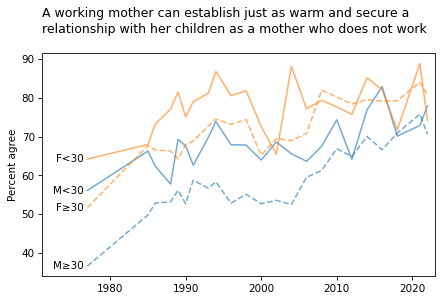

In [13]:
title = """A working mother can establish just as warm and secure a
relationship with her children as a mother who does not work
"""
plot_four_series_weighted('fechld', smooth=smooth)
plt.title(title, loc='left');

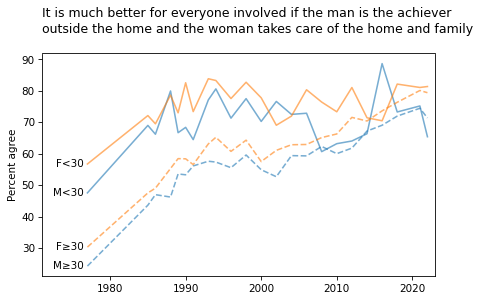

In [14]:
title = """It is much better for everyone involved if the man is the achiever 
outside the home and the woman takes care of the home and family
"""
plot_four_series_weighted('fefam', smooth=smooth)
plt.title(title, loc='left');

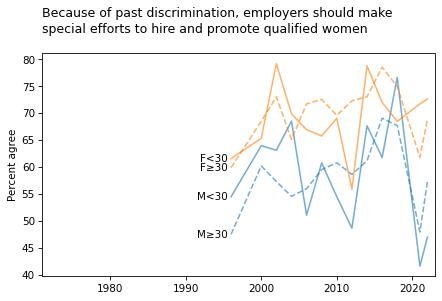

In [15]:
title = """Because of past discrimination, employers should make 
special efforts to hire and promote qualified women
"""
plot_four_series_weighted('fehire', smooth=smooth)
plt.title(title, loc='left');

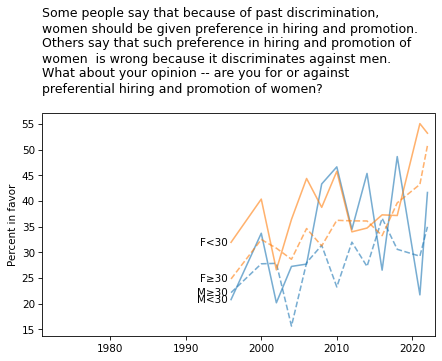

In [16]:
title = """Some people say that because of past discrimination, 
women should be given preference in hiring and promotion. 
Others say that such preference in hiring and promotion of 
women  is wrong because it discriminates against men. 
What about your opinion -- are you for or against 
preferential hiring and promotion of women?
"""
plot_four_series_weighted('fejobaff', smooth=smooth)
plt.title(title, loc='left')
plt.ylabel('Percent in favor');

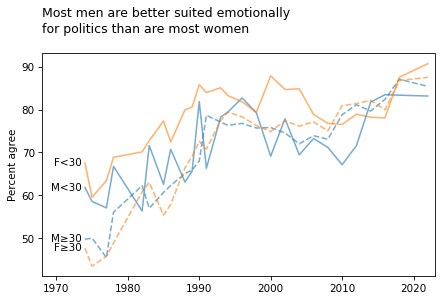

In [17]:
title = """Most men are better suited emotionally
for politics than are most women
"""
plot_four_series_weighted('fepol', smooth=smooth)
plt.title(title, loc='left')
plt.xlim([1968, 2023]);

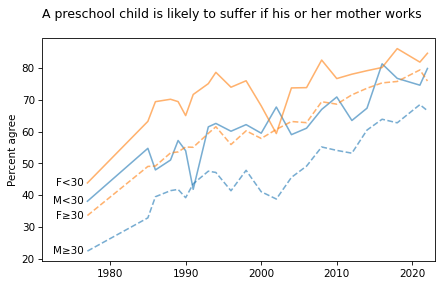

In [18]:
title = """A preschool child is likely to suffer if his or her mother works
"""
plot_four_series_weighted('fepresch', smooth=smooth)
plt.title(title, loc='left');

## Bayesian IRT

Some questions are more "difficult" than others, so it's hard to compare people who answer different subsets of the questions. We can address this with item response theory, which uses actual responses to infer an underlying propensity to give feminist responses. Then we use these propensities to predict how many feminist responses each respondent would give if they answered all of the questions.

In [19]:
# columns = set(current_columns).difference(['fejobaff', 'fehire'])
columns = set(current_columns)
columns

{'fechld', 'fefam', 'fehire', 'fejobaff', 'fepol', 'fepresch'}

Extract the relevant columns.

In [20]:
questions = pd.DataFrame(dtype=float)

for column in columns:
    questions[column] = gss[column].isin(fem_responses[column]).astype(float)
    null = gss[column].isna()
    questions.loc[null, column] = np.nan

The difficulty of each question is based on the overall fraction of respondents who got it "right".

In [21]:
questions.mean().sort_values()

fejobaff    0.345388
fepresch    0.599174
fehire      0.635895
fefam       0.639948
fechld      0.689478
fepol       0.720369
dtype: float64

In [22]:
from scipy.special import logit

ds = -logit(questions.mean().values)
ds

array([-0.79768068, -0.57513683,  0.63937231, -0.94629101, -0.55759204,
       -0.40202423])

Most people were not asked any of the questions.
Of the ones who were asked any, most answered more than 3.

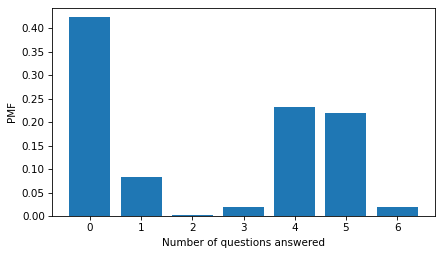

In [23]:
from empiricaldist import Pmf

answered = questions.notna().sum(axis=1)
Pmf.from_seq(answered).bar()

decorate(xlabel="Number of questions answered", ylabel="PMF")

In [24]:
(answered >= 3).mean()

0.4903439701616245

Here's how the inference works.
We start with a range of possible efficacies.

In [25]:
from scipy.special import expit

es = np.linspace(-6, 6, 21)

In [26]:
E, D = np.meshgrid(es, ds)
P = expit(E - D)
ns = P.sum(axis=0)

And make a non-informative prior for the distribution of efficacy.

In [27]:
from scipy.stats import norm
from empiricaldist import Pmf

ps = norm.pdf(es, 0, 4)
prior = Pmf(ps, es)
prior.normalize()

1.4751408263256967

As an example, we'll choose someone who answered 5 questions.

In [28]:
answered[answered>3]

7590     4
7591     4
7592     4
7593     4
7594     4
        ..
72380    5
72385    6
72386    4
72387    5
72389    5
Length: 34083, dtype: int64

In [29]:
row = questions.iloc[7594]
row

fechld      0.0
fefam       0.0
fejobaff    NaN
fepol       1.0
fehire      NaN
fepresch    0.0
Name: 7594, dtype: float64

They gave only one feminist response, so we think their efficacy is low.
Here's the Bayesian update.

In [30]:
E, D = np.meshgrid(es, ds)
P = expit(E - D)
Q = 1 - P
Q.shape

(6, 21)

In [31]:
# compute the likelihoods of the feminist responses
index1 = np.nonzero(row.values == True)
like1 = P[index1]

# compute the likelihoods of the non-feminist responses
index2 = np.nonzero(row.values == False)
like2 = Q[index2]

# multiply them all together
like = np.vstack([like1, like2]).prod(axis=0)

In [32]:
posterior = Pmf(prior.values * like, ns)
posterior.normalize()
posterior.mean(), posterior.std()

(1.4951546029740614, 1.0617811046871226)

And here's what the posterior distribution looks like.

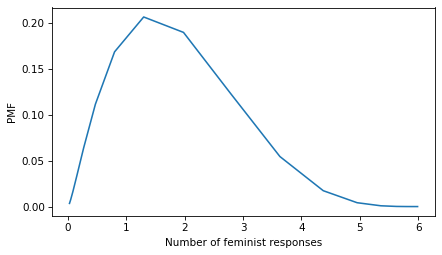

In [33]:
posterior.plot()
decorate(xlabel="Number of feminist responses", ylabel="PMF")

If they were asked all six questions, they would probably give 1-2 feminist answers, but the uncertainty is wide.

Now we can do the same thing for the whole dataset.

In [34]:
n, m = questions.shape
size = n, m, len(es)
res = np.empty(size)
res.shape

(72390, 6, 21)

In [35]:
a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [36]:
product = res.prod(axis=1) * prior.values
product.shape

(72390, 21)

In [37]:
posterior = product / product.sum(axis=1)[:, None]
posterior.shape

(72390, 21)

In [38]:
feminism = (posterior * ns).sum(axis=1)
feminism.shape

(72390,)

Here's what the distribution of estimates looks like.

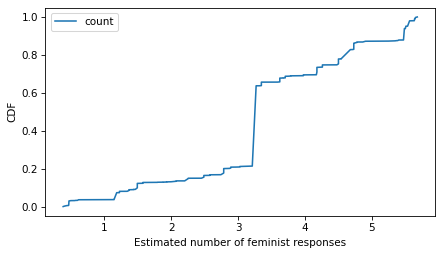

In [39]:
from empiricaldist import Cdf

Cdf.from_seq(feminism).plot()
decorate(xlabel="Estimated number of feminist responses", ylabel="CDF")

I'll write the results as a column in the DataFrame.

In [40]:
gss["feminism"] = pd.Series(feminism, gss.index)
gss.loc[answered < 3, "feminism"] = np.nan
gss["feminism"].describe()

count    35496.000000
mean         3.674580
std          1.616877
min          0.387473
25%          2.489252
50%          4.178290
75%          5.398978
max          5.677912
Name: feminism, dtype: float64

Now we can see how the responses have changed over time.

In [41]:
series = gss.groupby("year")["feminism"].mean()

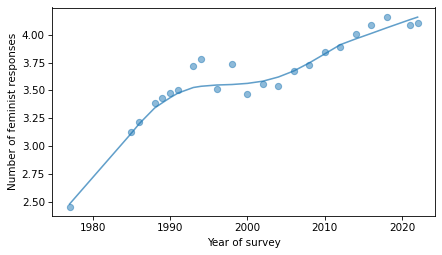

In [42]:
from utils import plot_series_lowess

plot_series_lowess(series, frac=0.5, color="C0", alpha=0.7, label="")
decorate(xlabel="Year of survey", ylabel="Number of feminist responses")

And we can plot time series broken down by age and gender.

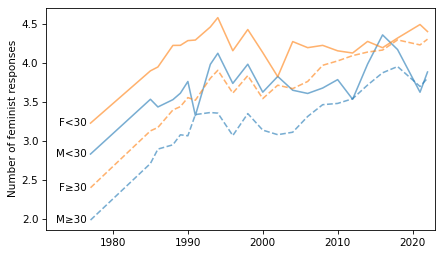

In [43]:
plot_four_series_weighted('feminism', smooth=False)
decorate(title="",
         ylabel="Number of feminist responses")

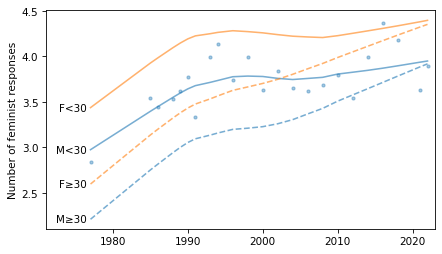

In [44]:
plot_four_series_weighted('feminism', smooth=True)
decorate(title="",
         ylabel="Number of feminist responses")